## Likelihood ratio classification

#### *26 October 2020*
#### *DATA 1010*

Consider a classification problem, wherein we have a probability measure on pairs of the form $(X,Y)$, where $X$ is a vector of features and $Y$ takes values in a finite set of categories. 

The **Bayes classifier** is the prediction function that minimizes the probability of misclassification. Given an observed feature vector, it returns the classification which is conditionally most probable given that feature vector.

In [1]:
using Plots, Distributions, Optim, Roots, LinearAlgebra, Statistics
gr(fontfamily = "Palatino", size = (400,400))

Plots.GRBackend()

## Problem 1

Suppose that each email is associated with a continuous spam score, and you want to distinguish spam emails from legitimate emails based on this score. Suppose that the spam score of a spam message is normally distributed with mean 21 and standard deviation 3, while the spam score of a legitimate message is normally distributed with mean 12 and standard deviation 2. Suppose further that the proportion of legitimate emails is $p$. 

For what value of $p$ is the critical spam score value for the Bayes classifier equal to 17? Hint: just take a numerical approach with `find_zero`. 

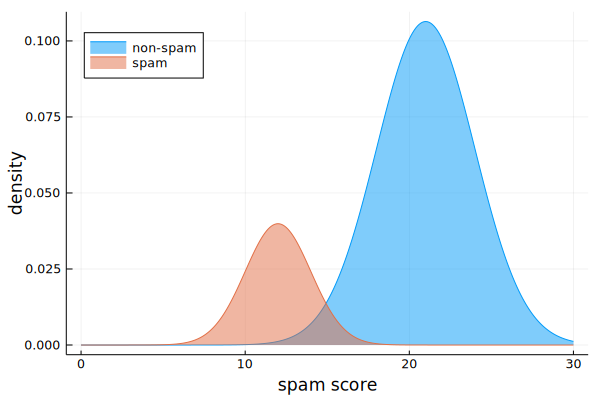

In [2]:
plot(0:0.1:30, x -> 0.8pdf(Normal(21,3),x), fillrange = 0, fillopacity = 0.5, legend = :topleft,
     label = "non-spam", xlabel = "spam score", ylabel = "density", size = (600,400))
plot!(0:0.1:30, x -> 0.2pdf(Normal(12,2),x), fillrange = 0, fillopacity = 0.5, label = "spam")

In [3]:
f_spam(x) = pdf(Normal(21,3),x)
f_legit(x) = pdf(Normal(12,2),x)

f_legit (generic function with 1 method)

In [4]:
find_zero( p -> (1-p) * pdf(Normal(21,3), 17) - p * pdf(Normal(12,2), 17), 0.5)

0.8618386661825437

In [5]:
function critical_value(p)
    find_zero(x -> (1-p)*f_spam(x) - p*f_legit(x), 15)
end

critical_value (generic function with 1 method)

In [6]:
p = find_zero(p -> critical_value(p) - 17, 0.5)

0.8618386661825437

## Problem 2

Continuing with the setup from Problem 1, suppose that the proportion of legimate messages is $p = 20\%$. 

If you want to penalize misclassifying a legitimate message as spam 5 times more than misclassifying a spam message as legitimate, what is the critical spam score value for the optimal classifier? Solve this problem in two different ways and show that your answers concur.

In [7]:
p = 0.2
find_zero(x -> (1-p)*f_spam(x) - 5*p*f_legit(x), 15)

16.011242781051624

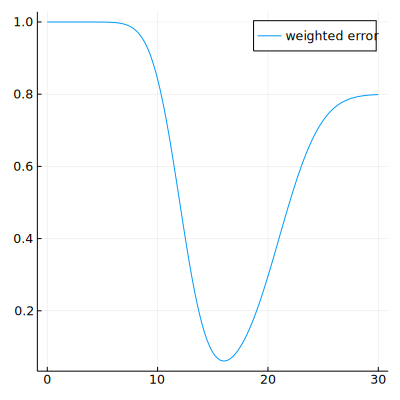

In [8]:
function weighted_misclassification(x)
    5*0.2ccdf(Normal(12,2), x) + 0.8cdf(Normal(21,3), x)
end

plot(0:0.05:30, weighted_misclassification, label = "weighted error")

In [9]:
optimize(x-> weighted_misclassification(first(x)), [15.0], BFGS()).minimizer

1-element Array{Float64,1}:
 16.011242781624315

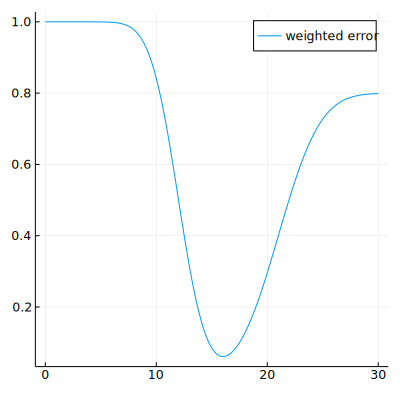

In [10]:
function weighted_misclassification_error(x)
    0.8cdf(Normal(21,3), x) + 5*0.2ccdf(Normal(12,2),x)
end

plot(0:0.05:30, weighted_misclassification_error, label = "weighted error")

--- 

The classifier you looked at in Problem 2 is an example of what's called a **likelihood ratio classifier** $h_t$: instead of comparing $\frac{f_{+1}(\mathbf{x})}{f_{-1}(\mathbf{x})}$ to $p_{-1}/p_{+1}$, we compare it to some other value $t \in (0,\infty)$. We can consider the false alarm rate and detection rates of the $h_t$ to get a curve called the **receiver operating characteristic**. 

## Problem 3


Consider the example from Data Gymnasia, where we consider class conditional densities given by unit-variance Gaussian distributions of means 0 and $\mu > 0$, and where the two classes have equal total mass. 

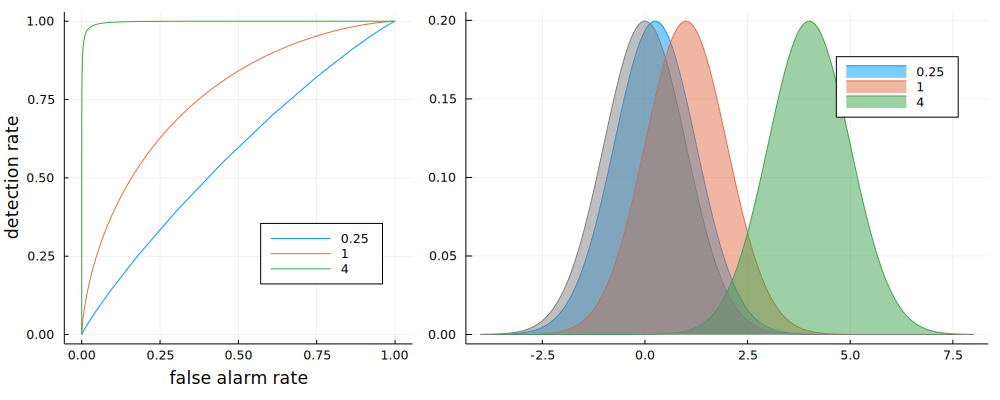

In [11]:
xgrid = -4:0.01:8
p = plot()
for μ ∈ (1/4, 1, 4)
    plot!(p, xgrid, x -> 0.5pdf(Normal(μ,1),x), fillrange = 0, fillopacity = 0.5, label = "$μ")
end
plot!(p, xgrid, x -> 0.5pdf(Normal(0,1),x), fillrange = 0, fillopacity = 0.5, color = :gray, label = "")

FAR(μ,t) = 1-cdf(Normal(0,1),log(t)/μ + μ/2)
DR(μ,t) = 1-cdf(Normal(μ,1),log(t)/μ + μ/2)
ROC(μ) = [(FAR(μ,t),DR(μ,t))
               for t in exp.(-20:0.1:20)]

plot(xlabel = "false alarm rate", ylabel = "detection rate",
     legend = :bottomright, aspect_ratio = 1)
for μ ∈ (1/4, 1, 4)
    plot!(ROC(μ),label="$μ")
end

plot(current(), p, size = (1000,400), layout = @layout([a{0.4w} b{0.6w}]))

For $\mu = 1$, plot the misclassification rate as a function of $t$, and observe that it has a minimum at $t = p_{-1}/p_{+1}$. 

In [12]:
function misclassification_probability(μ, t)
    p = 1/2
    critical_x = find_zero(x -> pdf(Normal(0,1),x) - t*pdf(Normal(μ,1),x), 0.5)
    ccdf(Normal(0,1), critical_x) + cdf(Normal(μ,1), critical_x)
end

misclassification_probability (generic function with 1 method)

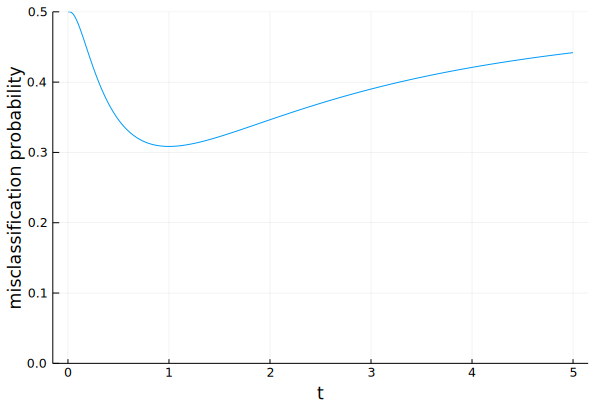

In [13]:
function misclassification_probability(t)
    x_crit = find_zero(x -> pdf(Normal(0,1), x) - t * pdf(Normal(1,1), x), 1.0)
    0.5ccdf(Normal(0,1), x_crit) + 0.5cdf(Normal(1,1), x_crit)
end

plot(0:0.01:5, misclassification_probability, size = (600,400), 
     ylims = (0,0.5), legend = false, ylabel = "misclassification probability", xlabel = "t")

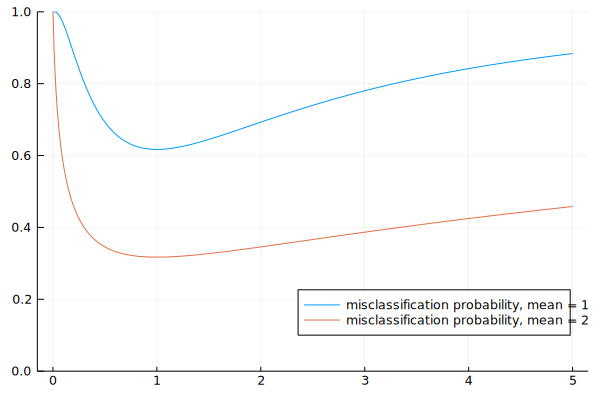

In [14]:
plot(0:0.01:5, t -> misclassification_probability(1, t), size = (600,400),
    label = "misclassification probability, mean = 1", ylims = (0,1), legend = :bottomright)
plot!(0:0.01:5, t -> misclassification_probability(2, t), size = (600,400),
    label = "misclassification probability, mean = 2", ylims = (0,1), legend = :bottomright)

## Problem 4

One important practical point about the ROC is that you can plot an empirical approximation without using density estimations at all. 

Draw 100 observations from the joint distribution on features and labels in the previous paragraph (equally likely normal distributions with unit variance and means 0 and $\mu = 2$), and approximate the ROC by finding the empirical detection rate and false alarm rate for various possible threshold feature values.

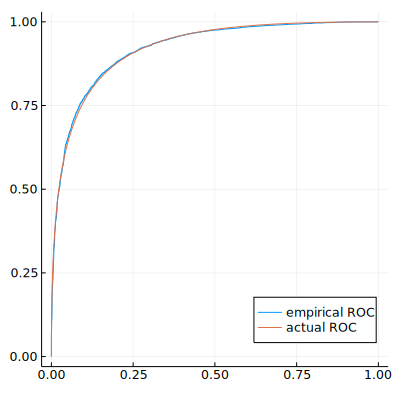

In [16]:
n = 10000
neg = []
pos = []
for i = 1:n
    if rand() < 0.5
        push!(neg, rand(Normal(0,1)))
    else
        push!(pos, rand(Normal(2,1)))
    end
end
obs = sort([pos; neg])
critical_xs = 0.5(obs[1:end-1] + obs[2:end])
DR(neg, pos, x) = count(pos .> x) / length(pos)
FAR(neg, pos, x) = count(neg .> x) / length(neg)
plot([(FAR(neg, pos, x), DR(neg, pos, x)) for x in critical_xs], legend = :bottomright, label = "empirical ROC")
plot!(ROC(2), label = "actual ROC")